# Class 03-3 미분의 구현

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sympy

sympy.init_printing()

style_name = 'bmh' #bmh
mpl.style.use(style_name)
np.set_printoptions(precision=4, linewidth =150)

style = plt.style.library[style_name]
style_colors = [ c['color'] for c in style['axes.prop_cycle'] ]

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## 미분 구현

- 미분을 컴퓨터로 계산하기 위한 방법을 배운다.


- 심볼릭 연산
    - Sympy, Mathematica, Wolfram alpha 같은 소프트웨어로 손으로 계산한것처럼 도함수를 구할 수 있다.
    
    
- 코드 구현 : 도함수를 심볼릭하게 구하는 것이 아니라 특정 점에서 미분계수를 구한다.
    - 직접 미분
    - 수치 미분
    - 그래프 방식 미분

### 직접 미분

- 제목처럼 미분을 직접해서 코드로 적어 줌

- 아래와 같은 함수의 경우 다음처럼 `python`으로 `f(x)`, `df(x)`를 직접 정의 해준다.

$$
f(x)=(x^2+2x) \ln x
$$

```python
f = lambda x : (x**2 + 2*x)*np.log(x)

df = lambda x : 2*(x+1)*np.log(x) + (x+)
```

- 장점 : 정확한 결과, 빠른 속도

- 단점 : 미분을 해야 한다!!!


In [2]:
f = lambda x : (x**2 + 2*x)*np.log(x)
df = lambda x : 2*(x+1)*np.log(x) + (x+2)

print(f(1))
print(df(1))

0.0
3.0


In [3]:
x = sympy.Symbol('x')
sympy.simplify(sympy.diff((x**2 + 2*x)*sympy.log(x), x))

### 수치 미분<sup>[arora]</sup>

- 미분의 정의를 수치적으로 구현

- 아주 작은 독립변수의 변화 $\Delta x$로 종속변수의 변화 $\Delta y$를 실제로 계산

- 이 둘을 나누어 특정점에서의 미분 계수를 근사

- 장점 : 구현이 간단하다.

- 단점 : 다변수 함수의 경우 모든 변수에 대해 같은 계산을 반복해야하므로 변수가 많으면 매우 느리다.

- 활용 : 머신러닝에서는 주로 그래프 방식의 미분 계산이 정확한지 확인할 목적으로 사용함.

#### 전방차분법
$$
\frac{\partial \, f}{\partial \, x_i} \approx \frac{f(x_1, \cdots, \color{RoyalBlue}{x_i + \Delta x_i} , \cdots, x_n) - f(x_1, \cdots, x_i, \cdots, x_n)}{\Delta x_i}
$$

#### 후방차분법
$$
\frac{\partial \, f}{\partial \, x_i} \approx \frac{f(x_1, \cdots, x_i, \cdots, x_n)-f(x_1, \cdots, \color{RoyalBlue}{x_i - \Delta x_i} , \cdots, x_n) }{\Delta x_i}
$$

#### 중앙차분법
$$
\frac{\partial \, f}{\partial \, x_i} \approx \frac{f(x_1, \cdots, \color{RoyalBlue}{x_i+\frac{1}{2}\Delta x_i}, \cdots, x_n)-f(x_1, \cdots, \color{RoyalBlue}{x_i - \frac{1}{2} \Delta x_i} , \cdots, x_n) }{\Delta x_i}
$$

- 아래 실험코드로 중앙차분법과 전방차분법의 오차 정도를 알아 볼 수 있다.

In [4]:
############################################################
# x^4의 해석적 미분
############################################################
def f(x) :
    """
    미분할 함수를 정의
    """
    # return np.exp(np.sin(x))
    return x**4

def fdot(x):
    """
    직접 구한 도함수를 정의, sympy등을 사용하여 구할 수 있음
    """
    # return np.exp(np.sin(x))*np.cos(x)
    return 4*x**3

In [5]:
from matplotlib.patches import ConnectionPatch

############################################################
# 수치미분함수
############################################################
def numer_deriv(f, x, h=0.01, method='center', args=()) :
    """
    f      : 미분할 함수, 주어진 위치에서 함수값 계산
    x      : 미분계수를 구할 변수의 위치로 일변수인 경우 float, 다변수인 경우 (d,) 벡터
    h      : finite difference
    method : 중앙차분:center, 전방차분:forward
    args   : 미분할 함수 f에서 추가적으로 받아들이는 인자들
    """
    if type(x) in (float, int, np.float32, np.float64) :
        grad = [0.0]
        x_ = [x]
        var_type = 'scalar'
    else :
        grad = np.zeros(x.shape)
        x_ = x.copy().astype('float32')
        var_type = 'vector'
    
    for i, xi in enumerate(x_) :
        original_value = x_[i]
        
        if method=='forward' :
            x_[i] = original_value + h
        else :
            x_[i] = original_value + (h/2)
            
        if var_type == 'scalar' :
            gradplus = f(x_[i], *args)
        else :
            gradplus = f(x_, *args)
        
        if method=='forward' :
            x_[i] = original_value
        else:
            x_[i] = original_value - (h/2)
            
        if var_type == 'scalar' :
            gradminus = f(x_[i], *args)
        else :
            gradminus = f(x_, *args)
        
        grad[i] = (gradplus - gradminus) / h
    
    if var_type == 'scalar' :
        return grad[0]
    else :
        return grad


In [6]:
############################################################
# 기울기를 그리는 보조 함수
############################################################
def draw_slope(pts, ax1, ax2, eps=1.0e-5, method='center', itv=0.45) :
    """
    eps : 구간 크기
    method : 'center', 'forward'
    ivt : 기울기선 그림그리는 간격지정
    """
    
    for x in pts :
        ax1.plot(x, f(x), 'o', markersize=10, color=style_colors[0], zorder=3)
        ax2.plot(x, fdot(x), 'o', markersize=10, color=style_colors[1], zorder=3)
        
        con = ConnectionPatch(xyA=(x, fdot(x)), xyB=(x, f(x)), ls='--', coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1, color=style_colors[3], lw=2, alpha=0.6,
                      arrowstyle="<|-", mutation_scale=20, fc="w", zorder=2)
        ax2.add_artist(con)
        
        #numerical deriv.
        diff = numer_deriv(f, x, eps, method)
        
        if method=='forward' :
            # 전방차분으로 계산되는 기울기 직선을 그린다.
            ax1.plot([x, x+eps], [f(x), f(x+eps)], lw=2, color=style_colors[4])
            
        else :
            # 중앙차분으로 계산되는 기울기 직선을 그린다.
            ax1.plot([x-eps/2, x+eps/2], [f(x-eps/2), f(x+eps/2)], lw=2, color=style_colors[4])
        
        # 미분하는 위치에서 기울기 직선을 그린다.
        ax1.plot([x-itv, x+itv], [f(x)-fdot(x)*itv, f(x)+fdot(x)*itv], lw=2, color=style_colors[1])
        
        ax1.text(x + 0.1 ,f(x)+0.2, "Slope {:.2f}".format(diff), fontsize=13)
        ax2.text(x + 0.1 ,fdot(x)+0.2, "value {:.2f}".format(fdot(x)), fontsize=13)

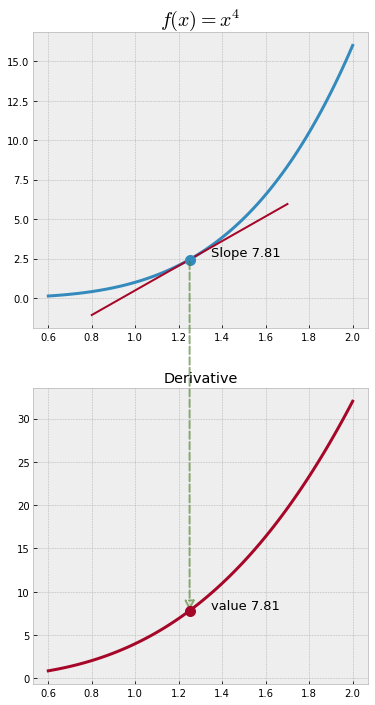

In [7]:
fig = plt.figure()
fig.set_size_inches((6,12))

ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

x = np.linspace(0.6, 2, 100)
#x = np.linspace(0, 2, 200)
slope_points = [1.25] 

ax1.plot(x, f(x), color=style_colors[0], lw=3)
ax1.set_title(r"$f(x)=x^4$", fontsize=20)

ax2.plot(x, fdot(x), color=style_colors[1], lw=3)
ax2.set_title(r"Derivative")

# foward, central 을 바꿔가면서 정확도를 확인해 볼 수 있다.
draw_slope(slope_points, ax1, ax2, eps=0.01, method='center')

plt.show()

#### 다변수 함수에 대한 수치 미분 실험

- 주어진 함수

$$
f(x,y) = (x^2 + 2x)\ln(y)
$$

In [8]:
f_xy = lambda x: (x[0]**2 + 2*x[0])*np.log(x[1])
numer_deriv(f_xy, np.array([1, 2]))

array([2.7726, 1.49  ])

### 자동미분Automatic Differentiation(그래프 방식)<sup>[nocedal, Géron]</sup>

- 복잡한 함수를 작은 연산 단위로 분리하여 각각에 대해 미분계수를 곱하고 체인룰을 적용하여 모두 곱하는 방식

- 종류 : 포워드 모드<sup>forward mode [nocedal, Géron]</sup>, 리버스 모드<sup>reverse mode</sup>

- 포워드 모드는 방향미분<sup>directional derivative,[wiki:direc_deriv]</sup> 개념이 필요하므로 본 수업의 범위를 벗어나며 여기서는 리버스 모드만 다룸


- 리버스 모드
    - 순전파: 함수를 그래프 방식으로 나열한 후 순차적인 +, -, *, /를 적용하여 함수값을 계산
    - 역전파 : 연쇄법칙을 사용하여 미분계수를 계산


- 장점 : 복잡한 함수의 미분도 루틴의 반복으로 계산, 빠른 속도

- 단점 : 무슨 소리하는지 잘 모를 수 있다?! 구현 어려움

- 활용 : 신경망의 역전파 알고리즘

In [9]:
import torch # 파이토치 불러오기

In [10]:
torch.cuda.is_available()

True

#### 파이토치

- PyTorch is a Python-based scientific computing package serving two broad purposes:
    - A replacement for NumPy to use the power of GPUs and other accelerators.
    - An automatic differentiation library that is useful to implement neural networks

#### 파이토치 텐서

- 물리학에서 물리량을 표현하기 위한 수학적 도구

- 인공지능 분야에서는 다차원 배열

- 넘파이 어레이와 파이토치 텐서는 상호 변환 가능


In [11]:
np.random.seed(0) # 랜덤 어레이 생성에서 늘 같은 결과가 나오게 하기 위해

x = np.random.rand(6).reshape(2,3)

x_tensor = torch.tensor(x)
x_from_numpy = torch.from_numpy(x)
x_Tensor = torch.Tensor(x)
x_as_tensor = torch.as_tensor(x)

print(x, x.dtype)
print(x_tensor, x_tensor.dtype, x_tensor.requires_grad)
print(x_from_numpy, x_from_numpy.dtype, x_from_numpy.requires_grad)
print(x_Tensor, x_Tensor.dtype, x_Tensor.requires_grad)
print(x_as_tensor, x_as_tensor.dtype, x_as_tensor.requires_grad)

[[0.5488 0.7152 0.6028]
 [0.5449 0.4237 0.6459]] float64
tensor([[0.5488, 0.7152, 0.6028],
        [0.5449, 0.4237, 0.6459]], dtype=torch.float64) torch.float64 False
tensor([[0.5488, 0.7152, 0.6028],
        [0.5449, 0.4237, 0.6459]], dtype=torch.float64) torch.float64 False
tensor([[0.5488, 0.7152, 0.6028],
        [0.5449, 0.4237, 0.6459]]) torch.float32 False
tensor([[0.5488, 0.7152, 0.6028],
        [0.5449, 0.4237, 0.6459]], dtype=torch.float64) torch.float64 False


- 텐서가 만들어진 방법에 따라 데이터의 공유 상태를 확인해보자.

In [12]:
x[0,0] = 100

print(x, x.dtype)
print(x_tensor, x_tensor.dtype, x_tensor.requires_grad)
print(x_from_numpy, x_from_numpy.dtype, x_from_numpy.requires_grad)
print(x_Tensor, x_Tensor.dtype, x_Tensor.requires_grad)
print(x_as_tensor, x_as_tensor.dtype, x_as_tensor.requires_grad)

[[100.       0.7152   0.6028]
 [  0.5449   0.4237   0.6459]] float64
tensor([[0.5488, 0.7152, 0.6028],
        [0.5449, 0.4237, 0.6459]], dtype=torch.float64) torch.float64 False
tensor([[100.0000,   0.7152,   0.6028],
        [  0.5449,   0.4237,   0.6459]], dtype=torch.float64) torch.float64 False
tensor([[0.5488, 0.7152, 0.6028],
        [0.5449, 0.4237, 0.6459]]) torch.float32 False
tensor([[100.0000,   0.7152,   0.6028],
        [  0.5449,   0.4237,   0.6459]], dtype=torch.float64) torch.float64 False


`torch.from_numpy()`와 `torch.as_tensor()`만 값이 바뀜

In [13]:
x_tensor_grad = torch.tensor(x, requires_grad=True)

print(x_tensor_grad, x_tensor_grad.dtype, x_tensor_grad.requires_grad)

tensor([[100.0000,   0.7152,   0.6028],
        [  0.5449,   0.4237,   0.6459]], dtype=torch.float64,
       requires_grad=True) torch.float64 True


In [14]:
x = torch.tensor([1.0], requires_grad=True)
f = (x**2 + 2*x) * torch.log(x)

print(x)
print(f)
print(x.grad)

print(x.grad_fn)
print(f.grad_fn)

tensor([1.], requires_grad=True)
tensor([0.], grad_fn=<MulBackward0>)
None
None


In [15]:
# x가 마지막 노드인가? 
# backward()함수는 마지막 노드까지 역전파하면서 미분계수를 구한다.
print(x.is_leaf)

True


#### torch.autograd.backward

In [16]:
torch.autograd.backward(f, grad_tensors=torch.tensor([2.]), retain_graph=True)
print(x.grad)

tensor([6.])


#### torch.autograd.grad

In [17]:
df = torch.autograd.grad(f, x, retain_graph=True)
print(df)

(tensor([3.]),)


In [18]:
print(x.grad)

tensor([6.])


- 다음 함수를 파이토치로 미분하기

$$
f(x,y) = (x^2 + 2x)\ln(y)
$$

In [19]:
x = torch.tensor([1.0], requires_grad=True)
y = torch.tensor([2.0], requires_grad=True)
f_xy = (x**2 + 2*x) * torch.log(y)

torch.autograd.backward(f_xy, retain_graph=True)
print(x.grad)
print(y.grad)

df = torch.autograd.grad(f_xy, (x,y), retain_graph=True)
print(df)

tensor([2.7726])
tensor([1.5000])
(tensor([2.7726]), tensor([1.5000]))


#### 수치 미분, 파이토치 자동미분 결과 비교

In [20]:
f_xy = lambda x: (x[0]**2 + 2*x[0])*np.log(x[1])
print(numer_deriv(f_xy, np.array([1, 2])))

[2.7726 1.49  ]


#### 자동 미분 초(超) 간단 예

- 다음 함수에 있어서 자동 미분 방식으로 미분을 계산


$$
z(x,y) = xy
$$

- 각각을 그냥 손으로 미분하면 다음과 같음을 이미 알고 있다.

$$
\frac{\partial z}{\partial x} = y \quad \frac{\partial z}{\partial y} = x
$$

- $x$로 미분하면 $y$가 되고, $y$로 미분하면 $x$가 되어 미분하는 변수의 반대로 결과가 나온다.

- 위 함수를 아래처럼 동그라미 노드는 연산, 화살표는 숫자의 흐름을 의미하게 그래프로 그림.

<img src="imgs/autodiff1.png" width="550">

- 위 그래프 $x=3$, $y=2$를 대입하고 그래프의 왼쪽에서 오른쪽으로 진행하면서 계산하면 $z=6$이 된다. 이 과정을 순전파라고 함

- 위 손 미분에서 결과가 반대로 나온다는 사실로 인해 $x=3$, $y=2$에서의 각 편도함수의 값은 $\dfrac{\partial z}{\partial x}= 2$, $\dfrac{\partial z}{\partial y}= 3$이고 이는 아무런 계산이 필요없이 그냥 입력의 위치만 바꿔주면 됨

- 이제 아무것도 안하는 $z$를 입력받고 $z$를 출력하는 노드 하나를 마지막에 붙이고 

- 최종 결과 $h$를 $x$로 미분하면 마지막 함수$I(z)$는 함수값에 전혀 변화를 주지 않으므로 결과는 여전히 $\dfrac{\partial h}{\partial x}= 2$

<img src="imgs/autodiff2.png" width="550">

- 마지막은 $z$를 입력받아 $h$를 출력하는 함수이므로 $x$의 함수가 아니라 $z$의 함수이므로 다음과 같이 체인룰을 적용한다.

$$
\frac{\partial h}{\partial x} = \frac{\partial h}{\partial z} \frac{\partial z}{\partial x}  
$$

- $\dfrac{\partial z}{\partial x}  $은 좀 전과 같고 새롭게 추가된 $\dfrac{\partial h}{\partial z}$만 계산해서 곱해주면 미분 완성

- $\dfrac{\partial h}{\partial z}=1$이므로 최종 결과는 변하지 않는다.

- 따라서 아래와 같은 루틴을 반복하는 것으로 복잡한 전체 미분을 완성할 수 있음.

> 최소 함수 단위로 쪼갠 다음 각각에 대해서 미분 계수를 계산하고 이를 다 곱해준다.

- 아래처럼 간단하게 코드로 구현할 수 있다.

In [21]:
def times(x, y):
    return x*y, (x,y)

def times_deriv(cache, dout=1):
    #       dx            dy
    return cache[1]*dout, cache[0]*dout

TIMES = {'f': times, 'df': times_deriv}
#  (2,3)
v, cache = TIMES['f'](2,3)
dx, dy = TIMES['df'](cache)

print("dx={}, dy={}".format(dx, dy))

dx=3, dy=2


#### 자동 미분 간단 예

- 계속 다루고 있는 다음 함수를 자동 미분 해보자.

$$
f(x,y) = (x^2 + 2x)\ln(y)
$$

- 그래프 표현

<img src="imgs/simple-1.png" width="700">

- 연산을 중심으로 단위 함수로 세분화 한다.


<img src="imgs/simple-2.png" width="700">

- 이제 위 그림에서 각 단위 함수별로 미분 계수를 계산해본다.

- 예를 들면 입력 $y$와 출력 $d$만을 고려하면 $d = \ln(y)$이므로 $\frac{\partial d}{\partial y} = \frac{1}{y}$임을 쉽게 알 수 있다.

- 이런 규칙으로 각 단위 함수에 대한 미분계수를 구해보자.

<img src="imgs/simple-3.png" width="700">

<img src="imgs/simple-4.png" width="500">

- 이제 각 변수에 대한 미분계수를 구하기 위해 연쇄법칙을 적용하고 연쇄법칙에 등장하는 미분계수를 위 표에서 찾아 곱하기먼하면 된다.

- $\frac{\partial f}{\partial y}$를 구해보면

<img src="imgs/simple-5.png" width="700">

- 그림의 실선을 따라가면서 미분 계수들을 곱하면 다음처럼 연쇄법칙이 완성되고 미분계수가 구해진다.

<img src="imgs/simple-6.png" width="300">

- $\frac{\partial f}{\partial x}$도 같은 방법으로 구할 수 있는데 이때는 이전 연쇄법칙을 다룰 때 알아봤듯이 변수로 들어오는 모든 경로의 미분계수를 더해주어야 한다.

<img src="imgs/simple-7.png" width="700">

- 그림에 나타난 경로 세개를 모두 아래처럼 더해주면 미분계수가 구해진다.

<img src="imgs/simple-8.png" width="700">

#### 자동 미분 간단 예 코드 구현

In [22]:
def add(x, y):
    return x+y, (x,y)

def add_deriv(cache, dout=1):
    return dout, dout

ADD = {'f': add, 'df': add_deriv}

def log(x):
    return np.log(x), x

def log_deriv(cache, dout=1):
    return (1/cache)*dout

LOG = {'f': log, 'df': log_deriv}

In [23]:
x = 1.; y = 2.

a, cache_a = TIMES['f'](x, x)
b, cache_b = TIMES['f'](2, x)
c, cache_c = ADD['f'](a, b)
d, cache_d = LOG['f'](y)
z, cache_z = TIMES['f'](c, d)

print("forward pass f(x) = {:.6f}".format(z))

dx = dy = 0.
dc, dd = TIMES['df'](cache_z, 1)
dy = LOG['df'](cache_d, dd)
da, db = ADD['df'](cache_c, dc)
_, dx_ = TIMES['df'](cache_b, db); dx+=dx_;
dx_, dx__ = TIMES['df'](cache_a, da); dx+=dx_+dx__;


print("backward pass dx = {:.6f}, dy = {:.6f}".format(dx, dy))

forward pass f(x) = 2.079442
backward pass dx = 2.772589, dy = 1.500000


#### 자동 미분 약간 복잡한 예제

- 다음 함수를 그래프 방식으로 미분해보자.



$$
\sigma(x) = \frac{1}{1+\exp(-x)}
$$

- 위 함수는 머신러닝에 자주 등장하는 로지스틱이라는 함수이므로 직접 미분을 해보는 것도 나쁘지 않다.

- 그래프 방식의 결과가 유효한지 확인을 위해서 일단 손으로 분수함수 미분법을 사용하여 미분한다.


$$
\begin{aligned}
\frac{d \sigma(x)}{dx} = \left( 1- \sigma(x) \right) \sigma(x)
\end{aligned}
$$


- 위 함수는 분수와 지수함수 $\exp$를 포함하고 있어 이를 위한 함수 객체가 필요하다.

- 다음처럼 지수 함수와, 역수 함수 게이트를 만든다.

- 이때 각함수의 미분은 다음의 결과를 이용한다.

$$ \frac{d}{dx} e^x = e^x$$

$$ \frac{d}{dx} \frac{1}{x} = - \frac{1}{x^2}$$



In [24]:
def exp(x):
    return np.exp(x), x

def exp_deriv(cache, dout=1):
    return np.exp(cache)*dout

EXP = {'f': exp, 'df': exp_deriv}


def inv(x):
    return 1./x, x

def inv_deriv(cache, dout=1):
    return -(1/cache**2)*dout

INV = {'f': inv, 'df': inv_deriv}

- 아래 그림처럼 함수를 최소단위의 합성함수로 분해한 후 그래프를 만들고 순전파, 역전파를 한다.

<img src="imgs/logistic-graph.png" width="700"/>


In [25]:
def logistic(x):
    # WRITE YOUR CODE HERE
    a, cache_a = 0,0
    b, cache_b = 0,0
    c, cache_c = 0,0
    d, cache_d = 0,0
    
    return ( (a, b, c, d), (cache_a, cache_b, cache_c, cache_d) )
            
def logistic_deriv(cache, dout=1):
    # WRITE YOUR CODE HERE
    cache_a, cache_b, cache_c, cache_d = cache
    
    dc    = 0,0
    db, _ = 0,0
    da    = 0,0
    dx, _ = 0,0
    
    return dx*dout

LOGISTIC = {'f': logistic, 'df': logistic_deriv}

In [26]:
x = 0.5
y = 1 / (1+np.exp(-x))
print("ANAL.")
print("1 / (1+np.exp(-{:.3f}))               = {:f}".format(x, y))       
print("Logistic func. derivative at x={:.3f} = {:f}".format(x, (1-y)*y))  
print("\n")

v, cache = LOGISTIC['f'](x)
dv = LOGISTIC['df'](cache)
print("AUTO DIFF.")
print("1 / (1+np.exp(-{:.3f}))               = {:f}".format(x, v[3]))       
print("Logistic func. derivative at x={:.3f} = {:f}".format(x, dv))  
print("\n")

ANAL.
1 / (1+np.exp(-0.500))               = 0.622459
Logistic func. derivative at x=0.500 = 0.235004


AUTO DIFF.
1 / (1+np.exp(-0.500))               = 0.000000
Logistic func. derivative at x=0.500 = 0.000000




- 위 결과로부터 로지스틱 함수의 미분 계수를 구하는 클래스를 제대로 작성하였음을 알 수 있다.

#### 자동 미분 조금 더 복잡한 예제<sup>[cs231n:backprop]</sup>

- 이 예제는 참고문헌 [cs231n:backprop]에서 발췌한 것으로 스탠포드 대학 딥러닝 강의 노트에 있는 예제이다.

- $x = 3$, $y = -4$에서 다음 함수의 함수값과 미분계수를 구하여라.

$$
z(x,y)=\frac{x+\sigma(y)}{\sigma(x)+(x+y)^2} 
$$

- 그냥 손미분하기 쉽지 않다. 

- 수치미분 또는 그래프 방식 미분으로 확인

<img src="imgs/example-graph3.png" width="700"/>

- 연휴 숙제

In [27]:
x = 3
y = -4

def my_func(x, y):
    """
    Define analytic function
    """
    return ( x + (1/(1+np.exp(-y))) ) / ( (1/(1+np.exp(-x))) + (x+y)**2 )

def dmy_func(x, y):
    sigma_x = 1/(1+np.exp(-x))
    sigma_y = 1/(1+np.exp(-y))
    
    numer = sigma_x + (x+y)**2 - ( (x+sigma_y)*((1-sigma_x)*sigma_x + 2*(x+y)) )
    denom = (sigma_x + (x+y)**2)**2
    dx = numer/denom
    
    numer = ((1-sigma_y)*sigma_y)*(sigma_x + (x+y)**2) - ( (x+sigma_y)*(2*(x+y)) )
    dy = numer/denom
    
    return dx, dy

def dmy_func_numer(x, y):
    """
    Numerical derivative to verify back-propagation
    """
    h = 0.001
    dx = (my_func(x+h/2, y) - my_func(x-h/2,y)) / h
    dy = (my_func(x, y+h/2) - my_func(x,y-h/2)) / h
    
    return dx, dy

def my_func_graph(x, y):
    z, dx, dy = 0., 0., 0.
    
    ######################################################
    # FORWARD FOR FUNCTION VALUE
    # WRITE YOUR CODE HERE
    ######################################################
    
    
    ######################################################
    # BACKWARD FOR DERIVATIVE
    # WRITE YOUR CODE HERE
    ######################################################
    

   
    
    return z, dx, dy

print("Analytic  : f={:f}, dx={:f}, dy={:f}".format(my_func(x,y), *dmy_func(x,y)))
print("Numerical : f={:f}, dx={:f}, dy={:f}".format(my_func(x,y), *dmy_func_numer(x,y)))
print("Graph     : f={:f}, dx={:f}, dy={:f}".format(*my_func_graph(x, y)))


Analytic  : f=1.545645, dx=2.059570, dy=1.592233
Numerical : f=1.545645, dx=2.059570, dy=1.592233
Graph     : f=0.000000, dx=0.000000, dy=0.000000


## 참고문헌

1. [arora] Intoruduction to Optimum Design 2nd ed., Jasbir S. Arora, Elsevier

1. [cs231n:backprop] Backpropagation, Intuitions, CS231n: Convolutional Neural Networks for Visual Recognition, http://cs231n.github.io/optimization-2/

1. [wiki:direc_deriv] Directional derivative,  https://en.wikipedia.org/wiki/Directional_derivative

1. [goodfellow] Deep Learning Book, Ian Goodfellow, Yoshua Bengio, Aaron Courville, MIT Press, 2016

In [28]:
from IPython.core.display import HTML

def _set_css_style(css_file_path):
   """
   Read the custom CSS file and load it into Jupyter.
   Pass the file path to the CSS file.
   """
   styles = open(css_file_path, "r").read()
   s = '<style>%s</style>' % styles     
   return HTML(s)

_set_css_style("../../style.css")